In [94]:
import pandas as pd
import numpy as np
import joblib
from sklearn import model_selection
from sklearn import metrics
df = pd.read_csv("../data/processed/wine_data_combined.csv")
cols_to_adjust = [x for x in df.columns if x not in ["quality", "is_red"]]
model_path = "../saved_models_testing/"
retrain = True  # Set to True and rerun the model gridsearches

In [95]:
# rm dooops
df = df.groupby(df.columns.tolist()).size().reset_index().\
    rename(columns={0:'records'})

In [96]:
df.groupby(df.columns.tolist()).size().reset_index().\
    rename(columns={0:'records'}).\
        drop("records", axis=1)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,0
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,0
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,0
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,0
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,15.0,0.210,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,1
5316,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5,1
5317,15.6,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5,1
5318,15.6,0.685,0.76,3.7,0.100,6.0,43.0,1.00320,2.95,0.68,11.2,7,1


TODO:
add: knn

In [97]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [98]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [99]:
multi_logistic_reg = LogisticRegression(penalty="elasticnet", solver="saga", tol=1e-2, max_iter=500)


# params_logistic = {"C": np.logspace(-5, 0, 100), "penalty": ["l1", "l2"]}
params_logistic = {"l1": np.logspace(-5, 0, 25),
                "l2": np.logspace(-5, -2, 25)}

logistic_grid_search = model_selection.GridSearchCV(
    multi_logistic_reg, params_logistic, n_jobs=cores)
# Not all of these converge given the low tolerance I set above


In [100]:
df_train, df_test = model_selection.train_test_split(
    df, test_size=0.3, random_state=55, stratify=df["quality"]
)

In [101]:
upper_quartile = np.quantile(scaled, 0.75, axis=0) * 2
scaled = np.where(scaled > upper_qujartile, np.nan, scaled)

NameError: name 'upper_qujartile' is not defined

In [102]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

stratified = model_selection.StratifiedKFold()
df_transform = ColumnTransformer(
    [(" ", StandardScaler(), cols_to_adjust)],
    remainder="passthrough",
)
df_train = pd.DataFrame(df_transform.fit_transform(df_train), columns=df.columns)
X_train = df_train.drop("quality", axis=1)
y_train = pd.Categorical(df_train["quality"], ordered=True)

In [103]:
already_scaled = X_train[["is_red", "records"]].to_numpy()
scaled = X_train.drop(["is_red", "records"], axis=1)

# anything 3x larger than scaled iqr is gona get replaced
# by a knn inpute
upper_quartile = np.quantile(scaled, 0.75, axis=0) * 2
scaled = np.where(scaled > upper_quartile, np.nan, scaled)
lower_quartile = np.quantile(scaled, 0.25, axis=0) * 2
scaled = np.where(scaled < lower_quartile, np.nan, scaled)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
inputed = imputer.fit_transform(scaled)

X_train = np.concatenate((inputed, already_scaled), axis=1)

In [104]:
df_test = pd.DataFrame(df_transform.fit_transform(df_test), columns=df.columns)
X_test = df_test.drop("quality", axis=1)
y_test = pd.Categorical(df_test["quality"], ordered=True)

In [105]:
already_scaled = X_test[["is_red", "records"]].to_numpy()
scaled = X_test.drop(["is_red", "records"], axis=1)

# anything 3x larger than scaled iqr is gona get replaced
# by a knn inpute
scaled = np.where(scaled > upper_quartile, np.nan, scaled)
scaled = np.where(scaled < lower_quartile, np.nan, scaled)

inputed = imputer.fit_transform(scaled)

X_test = np.concatenate((inputed, already_scaled), axis=1)

# XGBoost

In [106]:
params_xgb = {
    "max_depth": np.arange(3, 20, 2),
    "colsample_bytree": np.arange(0.5, 1, 0.1),
    "learning_rate": np.logspace(-5, -1, 5),
}

In [107]:
type(X_train)

numpy.ndarray

In [108]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=3)
knn_inputed = knn_imputer.fit_transform(scaled)

def knn_impute_outliers(df, inputer, threash=0.9):
    new = np.where( (df > (np.quantile(df, threash, axis=0)) ) | ( df < (np.quantile(df, 1-threash, axis=0)) ), np.nan, df)
    print(new.shape)
    new = pd.DataFrame(new, columns=df.columns)
    return inputer.fit_transform(new)

knn_impute_outliers(X_train, knn_inputed)

(3724, 13)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [109]:
xgboost = xgb.XGBClassifier()
xgb_grid_search = model_selection.GridSearchCV(
    xgboost, params_xgb, n_jobs=cores
)

In [110]:
xgboost.fit(X_train, y_train)
xgboost.feature_importances_
# plt.barh(X_train.columns, xgb.feature_importances_)

array([0.06443051, 0.08494209, 0.07866795, 0.10086872, 0.07553089,
       0.08783784, 0.08083977, 0.1175193 , 0.08759653, 0.08204633,
       0.10014479, 0.00482625, 0.03474903], dtype=float32)

In [114]:
cols = [x.title().replace('_', ' ') for x in X_train.columns if x not in "quality"]
cols

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [113]:
xgboost.feature_importances_.shape

(13,)

In [93]:
len(cols)

14

ValueError: shape mismatch: objects cannot be broadcast to a single shape

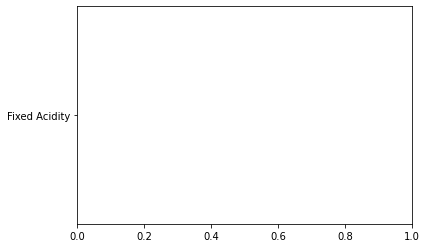

In [89]:
from matplotlib import pyplot as plt

plt.barh(cols, xgboost.feature_importances_)

In [82]:
df["dens_alch"] = df.density * df.alcohol
df["sugar_acid"] = df.residual_sugar * df.citric_acid * df.fixed_acidity
df["volat_density"] = df.volatile_acidity * df.density 

0       11.1
1        4.2
2        1.8
3        5.1
4        4.3
        ... 
5315     2.2
5316     4.2
5317     4.2
5318     3.7
5319     7.5
Name: residual_sugar, Length: 5320, dtype: float64

In [ ]:
xgb_grid_search.fit(X_train, y_train)

xgb_best_params = xgb.XGBClassifier(**xgb_grid_search.best_params_, probability=True)
models = []
models.append(("xgb", xgb_best_params))

np.sum(
    xgb_best_params.fit(X_train, y_train).predict(X_train) == y_train
) / X_train.shape[0]

/Users/josephdespres/my_env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
yhat = xgb_best_params.predict_proba(X_train)
metrics.roc_auc_score(y_train, yhat, multi_class='ovr')

0.9959759688099675

# Multinomeal Logistic Regression

In [ ]:
multi_logistic_reg = LogisticRegression(solver="saga", tol=1e-2, max_iter=500)
params_logistic = {"C": np.logspace(-5, 0, 100), "penalty": ["l1", "l2"]}
logistic_grid_search = model_selection.GridSearchCV(
    multi_logistic_reg, params_logistic, n_jobs=cores, cv=stratified
)

In [135]:
%%capture
# Not all of these converge given the low tolerance I set above
if retrain:
    logistic_grid_search.fit(X_train, y_train)
    joblib.dump(logistic_grid_search, "../saved_models/logistc_grid_search.joblib")

In [136]:
logistic_grid_search = joblib.load(f"{model_path}logistc_grid_search.joblib")
logistic_best_params = LogisticRegression(
    **logistic_grid_search.best_params_, solver="saga", tol=1e-2, max_iter=500

)
models.append(("logistic_reg", logistic_best_params))

In [137]:
yhat = logistic_best_params.fit(X_train, y_train).predict(X_train)
yhat = pd.Categorical(df_train["quality"], ordered=True)
np.sum(
    yhat == y_train
) / X_train.shape[0]
yhat = logistic_best_params.fit(X_train, y_train).predict_proba(X_train)



In [138]:
sum(logistic_best_params.predict(X_train) == y_train) / len(y_train)

0.5271213748657357

In [139]:
metrics.roc_auc_score(y_train, yhat, multi_class='ovr')

0.7792262440547716

# Support Vector Machines

In [140]:
support_vector_machine = svm.SVC(gamma="auto", probability=True, kernel="rbf")
params_svm = {"C": np.logspace(-3, 3, 500)}
svm_grid_search = model_selection.GridSearchCV(
    support_vector_machine, params_svm, n_jobs=cores, cv=stratified
)
if retrain:
    svm_grid_search.fit(X_train, y_train)
    joblib.dump(svm_grid_search, f"{model_path}svm_gridsearch.joblib")

/Users/josephdespres/my_env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [141]:
svm_grid_search = joblib.load(f"{model_path}svm_gridsearch.joblib")
svm_best_params = svm.SVC(
    gamma="auto", probability=True
)
svm_best_params.fit(X_train, y_train)
models.append(("svm", svm_best_params))
np.sum(svm_best_params.predict(X_train) == y_train) / X_train.shape[0]


metrics.roc_auc_score(y_train, svm_best_params.predict_proba(X_train), multi_class='ovo')

0.8393602864065928

In [142]:
sum(svm_best_params.predict(X_train) == y_train) / len(y_train)

0.5601503759398496

# Ensemble

In [143]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(models, voting="soft")

if retrain:
    ensemble.fit(X_train, y_train)
    joblib.dump(ensemble, f"{model_path}ensemble.joblib")

ensemble = joblib.load(f"{model_path}ensemble.joblib")

In [144]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(base_estimator=ensemble, n_estimators=10, random_state=0)

In [145]:
bagging = bagging.fit(X_train, y_train)

In [146]:
yhat = bagging.predict(X_train)
np.sum(yhat == y_train)/ len(y_train)

0.5628356605800214

In [147]:
yhat = bagging.predict(X_test)

In [148]:
np.sum(xgb_best_params.predict(X_test) == y_test) / len(y_test)

0.543859649122807

In [149]:
np.sum(bagging.predict(X_test) == y_test) / len(y_test)

0.5576441102756893

In [150]:
np.sum(yhat == y_test)/ len(y_test)

0.5576441102756893

In [151]:
from sklearn.metrics import confusion_matrix
conf = list(confusion_matrix(y_test, yhat))

In [152]:

from sklearn.pipeline import Pipeline

if not retrain:
    pipeline = Pipeline([("scaler", df_transform), ("bag", bagging)])
    pipeline.fit(,)
    joblib.dump(pipeline, f"{model_path}pipeline.joblib")

SyntaxError: invalid syntax (1588232010.py, line 5)

In [ ]:
pipeline = joblib.load(f"{model_path}pipeline.joblib")
np.sum(pipeline.predict(X_train) == y_train)/len(y_train)

/Users/josephdespres/my_env/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


0.7322771213748658